In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import torch.mps 
import itertools
import csv
from torchmetrics import Accuracy
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import cv2
from torchmetrics import Accuracy


In [2]:
# %%time
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")
    

MPS found


In [3]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
valid_folder_path = './data/FER2013Valid'

In [4]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Get the unique classes from the emotions column
        self.classes = self.img_frame.iloc[:, 2:].shape[1]
        
    def __len__(self):
        return len(self.img_frame)

#     to access elements using the []
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
#   to create the image name
        img_name = os.path.join(self.root_dir, self.img_frame.iloc[idx, 0])

        gray_image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        # color_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
        
        # image = io.imread(img_name)
        image = Image.fromarray(gray_image)
        emotions = self.img_frame.iloc[idx, 2:]
        emotions = np.asarray(emotions)
        emotions = emotions.astype('float32')

        sample = {'image': image, 'emotions': emotions} # a dictionary of an image with its label
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample #return a transformed image with label

In [5]:
def create_aug(aug):
    torch.manual_seed(17) #https://pytorch.org/vision/stable/transforms.html
    
    if aug:
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
            'valid': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
        }
        
    else: 
        data_transforms = {
            'train': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
            'valid': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
        }
    return data_transforms 

In [6]:
outputs_path = 'stats/debugging'

In [7]:
def write_to_table (epochs, optimizer ,criterion, batch_size, learning_rate, activation_func, elapsed_time,train_loss, train_accuracy, valid_loss, valid_accuracy, trial_id, scheduler, device_name, aug, weight_freezing): 
    with open(f'{outputs_path}/statistics.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        if csvfile.tell() == 0:
            # Write the column headers
            writer.writerow(['trial', 'Batch size', 'Epochs', 'Activation function', 'Loss function', 'Initial Learning rate', 'Optimizer', 'Scheduler',
                             'Min training loss', 'Average training loss', 'Max training loss', 
                             'Min training accuracy %', 'Average training accuracy %', 'Max training accuracy %',
                             'Min validation loss', 'Average validation loss', 'Max validation loss', 
                             'Min validation accuracy %', 'Average validation accuracy %',  'Max validation accuracy %', 
                             'Total time','Device', 'Data augmentation', 'Weight freezing'])

        # Write the row of data
        writer.writerow([trial_id, batch_size, epochs, activation_func, criterion, learning_rate, optimizer, scheduler,
                         round(min(train_loss), 2), round(sum(train_loss) / len(train_loss), 2), round(max(train_loss), 2),
                         round(min(train_accuracy), 2), round(sum(train_accuracy) / len(train_accuracy), 2), round(max(train_accuracy), 2),
                         round(min(valid_loss), 2), round(sum(valid_loss) / len(valid_loss), 2), round(max(valid_loss), 2),
                         round(min(valid_accuracy), 2), round(sum(valid_accuracy) / len(valid_accuracy), 2), round(max(valid_accuracy), 2),
                         time.strftime('%H:%M:%S', time.gmtime(elapsed_time)), device_name, aug, weight_freezing])

In [8]:
def create_plot(epochs, train_accuracy, valid_accuracy, train_loss, valid_loss):      
    # Plotting the loss and accuracy
    plt.figure(figsize=(10, 5))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_loss, label='Training')
    plt.plot(range(1, epochs+1), valid_loss, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracy, label='Training')
    plt.plot(range(1, epochs+1), valid_accuracy, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

In [9]:
def output_details_to_text (epochs, optimizer, scheduler ,criterion, batch_size, learning_rate, id):    
    # Create a file to write the output
    filename = f'{outputs_path}/trial_details/trial_{id+24}'
    output_file = open(filename, "w")

    output_file.write(f"Parameter Combination: \n")
    output_file.write(f"epochs: {epochs} \n")
    output_file.write(f"initial learning_rate: {learning_rate} \n")
    output_file.write(f"batch_size: {batch_size} \n")
    output_file.write(f"optimizer: {optimizer} \n")
    output_file.write(f"scheduler: {scheduler} \n")
    output_file.write(f"criterion: {criterion} \n")
    output_file.write(f"\n")
    
    output_file.write(f"Finished Training with this combination\n")
    
    output_file.write("#"*70)
    output_file.close()

In [10]:
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

In [11]:
def train_and_validate(epochs, optimizer, scheduler ,criterion, model, trainloader, validloader, batch_size, learning_rate, activation_func, trial_id, device, aug, weight_freezing):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    opt_name = optimizer.__name__
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    
    if scheduler == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = scheduler(optimizer)
        
    elif scheduler == optim.lr_scheduler.ExponentialLR: 
        scheduler = scheduler(optimizer, gamma=0.9)
        
    st = time.time()

# Training - Validation loop
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        # Perform training
        for i, data in enumerate(trainloader, 0):
            labels = data['emotions'].to(device)
            inputs = data['image'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print(f"loss {i}: {loss}")
            running_loss += loss.item() 
            # print(f"running loss {i}: {running_loss}")
            # Calculate and store training accuracy
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            
            # total += labels.size(0) 
            # correct +=  (predicted == labels).sum().item()
            # print("1 more correct..")
        
        if type(scheduler) == optim.lr_scheduler.ReduceLROnPlateau:
            scheduler.step(running_loss / len(validloader))
            
        else:        
            scheduler.step()
        # print("==============================================")        
        # print("==============================================")        
        # print("==============================================")        
        train_loss.append(running_loss / len(trainloader))
        # print(f"train loss: {train_loss}")
        train_accuracy.append(100 * torchmetrics_accuracy(predicted, labels).item())
        # print(f"training accuracy: {train_accuracy}")
        # Perform validation
        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        
        with torch.inference_mode():
            for data in validloader:
                labels = data['emotions'].to(device)
                images = data['image'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                
                total += labels.size(0)
                correct +=  (predicted == labels).sum().item() #can be torch.eq(pred, labels).sum().item()
        
        valid_loss.append(running_loss / len(validloader))
        # print(torchmetrics_accuracy(predicted, labels).item())
        # print(torchmetrics_accuracy(predicted, labels))
        
        valid_accuracy.append(100 * torchmetrics_accuracy(predicted, labels).item())
        # print (f"validation accuracy: {valid_accuracy}")
      

    elapsed_time = time.time() - st


    if device == torch.device("cpu"):
            device_name = 'CPU'
    elif device == torch.device("mps"):
            device_name = 'MPS'
            
            # save the model
    # torch.save(model.state_dict(), f'./models/RESNET/RESNET-18_{trial_id}.pth')     
    
    write_to_table(epochs, opt_name, criterion, batch_size, learning_rate, activation_func.__name__, elapsed_time, train_loss, train_accuracy, valid_loss, valid_accuracy, trial_id, scheduler.__class__.__name__, device_name, aug, weight_freezing)
    
    create_plot(epochs, train_accuracy, valid_accuracy, train_loss, valid_loss)
    
    # output_details_to_text(epochs, optimizer, scheduler.__class__.__name__, criterion, batch_size, learning_rate, iteratior_id)

In [14]:
# Define parameter grids
criterions = [nn.CrossEntropyLoss()]
optimizers = [optim.Adam]
activations = [F.relu]
learning_rates = [0.001]
epochs = [10]
batch_size = [32]
schedulers = [optim.lr_scheduler.ExponentialLR]
devices = [torch.device("mps")]
aug = [False]
weight_freezing = [False]

# Create all possible parameter combinations
parameter_grid = itertools.product(learning_rates, batch_size, epochs, schedulers, optimizers, activations, criterions, devices, aug, weight_freezing)

In [15]:
for i, params in enumerate(parameter_grid):
    learning_rate, batch_size, epochs, scheduler, optimizer, activation, criterion, device, aug, weight_freezing = params 
    
    data_transforms = create_aug(aug)
    
    train_dataset = FERPlusDataset(os.path.join(train_folder_path,"label.csv"), train_folder_path, transform=data_transforms['train'])
    valid_dataset = FERPlusDataset(os.path.join(valid_folder_path, "label.csv"), valid_folder_path, transform=data_transforms['valid'])
    # test_dataset = FERPlusDataset(os.path.join(test_folder_path, "label.csv"), test_folder_path, transform=data_transforms['val'])
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    if weight_freezing:
        for param in model.parameters():
            param.requires_grad = False
    
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    num_classes = train_dataset.classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model.to(device)
    train_and_validate(epochs, optimizer, scheduler , criterion, model, trainloader, validloader, batch_size, learning_rate, activation, i, device, aug, weight_freezing)
    plt.savefig(f"{outputs_path}/plots/trial{i} act_func={activation.__name__}, loss_func={criterion.__class__.__name__}, opt={optimizer.__name__}, LRS={scheduler.__name__} .png")
    plt.close()
    plt.close('all')
    # make sure there is no memory leaks .. not working as expected 
    torch.mps.empty_cache()
    # clear ram
    del model
    # free memory
    import gc
    gc.collect()
    # free dataloader memory 
    del trainloader
    del validloader

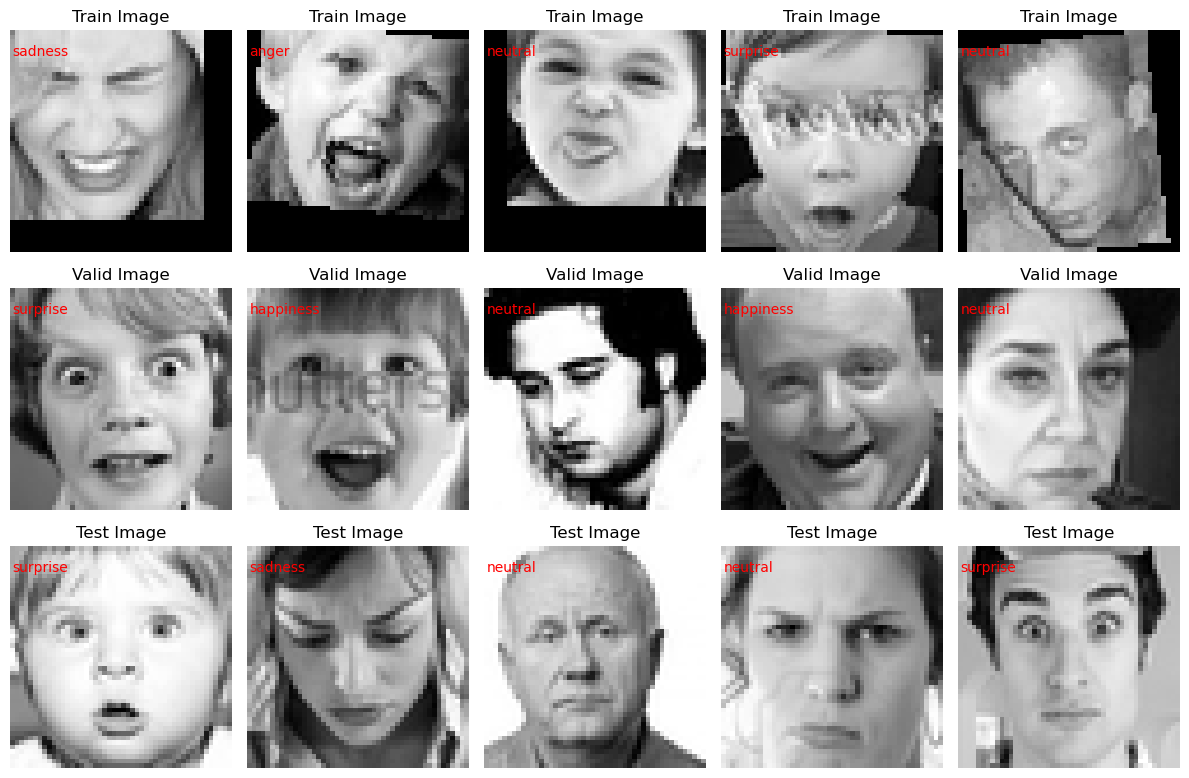

In [17]:
## Just for Debugging
data_transforms = create_aug(True)
train_dataset = FERPlusDataset(os.path.join(train_folder_path,"label.csv"), train_folder_path, transform=data_transforms['train'])
valid_dataset = FERPlusDataset(os.path.join(valid_folder_path, "label.csv"), valid_folder_path, transform=data_transforms['valid'])
test_dataset = FERPlusDataset(os.path.join(test_folder_path, "label.csv"), test_folder_path, transform=data_transforms['valid'])
# Define the emotion labels
emotion_labels = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']

# Randomly select and display images from the train set
train_indices = np.random.choice(len(train_dataset), size=5, replace=False)
train_images = [train_dataset[i]['image'] for i in train_indices]
train_labels = [train_dataset[i]['emotions'] for i in train_indices]

# Randomly select and display images from the validation set
valid_indices = np.random.choice(len(valid_dataset), size=5, replace=False)
valid_images = [valid_dataset[i]['image'] for i in valid_indices]
valid_labels = [valid_dataset[i]['emotions'] for i in valid_indices]

# Randomly select and display images from the test set
test_indices = np.random.choice(len(test_dataset), size=5, replace=False)
test_images = [test_dataset[i]['image'] for i in test_indices]
test_labels = [test_dataset[i]['emotions'] for i in test_indices]

# Display the images and labels
fig, axes = plt.subplots(3, 5, figsize=(12, 8))

for i, (image, label) in enumerate(zip(train_images, train_labels)):
    axes[0, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Train Image')
    axes[0, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

for i, (image, label) in enumerate(zip(valid_images, valid_labels)):
    axes[1, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Valid Image')
    axes[1, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

for i, (image, label) in enumerate(zip(test_images, test_labels)):
    axes[2, i].imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title('Test Image')
    axes[2, i].text(0, 5, emotion_labels[np.argmax(label)], color='red')

plt.tight_layout()
plt.show()

In [13]:
# dictionary for classess names in FERplus dataset
classes = {
    0: 'Neutral',
    1: 'Happinnes',
    2: 'Surprise',
    3: 'Sadness',
    4: 'Anger',
    5: 'Disgust',
    6: 'Fear',
    7: 'Contempt',
    8: 'Unknown',
    9: 'NF'
}

In [ ]:
idx = 1000

np_img = test_dataset[idx]['image']
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.show()
plt.close()
print (f"the original label was {classes[test_dataset[idx]['emotions'].argmax(0).item()]}\n")


In [14]:
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

In [40]:
test_dataset = FERPlusDataset(os.path.join(test_folder_path, "label.csv"), test_folder_path, transform=data_transforms['valid'])
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    


# test model on the test data set
import torch.nn.functional as F
import torch
def test_model(model, test_loader, dataset):
    model.to('cpu')
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_accuracy = []
    wrong = 0
    with torch.inference_mode():
        for i, data in enumerate(test_loader):
            labels = data['emotions']
            inputs = data['image']
            output = model(inputs)
            # print("out: ", output.shape)
            # print("labels: ", labels.shape)
            # print(labels.shape)
            # print(f"test loader length:  {len(test_loader)}")
            # show the first 10 images and their truth labels and their predictions
            if i < len(test_loader):
                for j in range(len(inputs)):
                    # if classes[labels[j].argmax(0).item()] != classes[output[j].argmax(0).item()] :
                    #     wrong +=1
                    
                    
                    file_name = "mymodel.txt"
                    output_file = open(file_name, "a")
                    prediction = classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]
                    
                    output_file.write(f"image: {i * batch_size + j} was {prediction}\n")
                    output_file.write(f"predicted label was: {classes[output[j].argmax(0).item()]} and the original label was {classes[labels[j].argmax(0).item()]}\n")
                    output_file.write("="*50)
                    output_file.write("\n")
                    # if j == 10:
                    #     print("one example:")
                    #     np_img = test_dataset[i * batch_size + j]['image']
                    #     plt.imshow(np.transpose(np_img, (1, 2, 0)))
                    #     plt.show()
                    #     plt.close()
                    #     print('-'*50)
                        
                    # print(labels[i].argmax().item())
                    # if classes[labels[j].argmax(0).item()] == classes[output[j].argmax(0).item()]:
                    #     print("hoppppaaaaaaaaaa")
                    #     print('image:', i * batch_size + j)
                        
                    #     print('truth:', classes[labels[j].argmax(0).item()])
                    #     print('prediction:', classes[output[j].argmax(0).item()])
                    #     print('='*50)
                    # plt.close('all')    
            output_file.close()
            # measure accuracy
            _, predicted = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            # torchmetrics_accuracy(predicted, labels)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_accuracy.append(torchmetrics_accuracy(predicted, labels))
        # print total accuracy
        print('Accuracy of the network on the test images: %d %%' % (
            100 * correct / total))
        print(f"correct: {correct}, total: {total}")
        print(test_accuracy)
test_model(model, testloader, test_dataset)

Accuracy of the network on the test images: 74 %
correct: 2671, total: 3572
[tensor(0.7812, device='mps:0'), tensor(0.6250, device='mps:0'), tensor(0.9375, device='mps:0'), tensor(0.8125, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.6875, device='mps:0'), tensor(0.6875, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.7812, device='mps:0'), tensor(0.8750, device='mps:0'), tensor(0.6875, device='mps:0'), tensor(0.7188, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.7812, device='mps:0'), tensor(0.7812, device='mps:0'), tensor(0.7188, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.6875, device='mps:0'), tensor(0.8125, device='mps:0'), tensor(0.7812, device='mps:0'), tensor(0.5938, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.7188, device='mps:0'), tensor(0.7812, device='mps:0'), tensor(0.7500, device='mps:0'), tensor(0.8750, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.6562, device='mps:0'), tensor(0.8125, device='mps:

In [44]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
model.load_state_dict(torch.load('./models/RESNET/RESNET-18_11.pth'))

<All keys matched successfully>

In [ ]:
model.to(device)
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
total_samples = 0

with torch.no_grad():
    for data in test_loader:
        labels = data['emotions'].to(device)
        images = data['image'].to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels, 1)
        
        test_loss += criterion(outputs, labels).item() 
        test_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
test_loss /= total_samples
test_accuracy = test_correct / total_samples

print(f'Test Loss: {test_loss:.4f} | Accuracy: {test_accuracy * 100:.2f}%')


1- change first layer 
2- documteation bta3 tranfer learning and resnet 
3- loss fix 
4- 